## Kaggle大赛第一步
前段时间学完了Udacity的深度学习基石课程，内容挺好，但是就是缺乏实战，于是找到了fast.ai的课程，准备进入kaggle大赛来检验下自己的学习成果，这是kaggle大赛第一步：入门。

下面是一些TODO LIST

1. 注册Kaggle的账号
2. 选择[dogs-vs-cats-redux-kernels-edition](https://www.kaggle.com/c/dogs-vs-cats-redux-kernels-edition)项目，选择同意数据协议（为了后面通过命令行下载数据用）
3. [aws环境搭建](http://wiki.fast.ai/index.php/AWS_install)
4. 数据目录准备

## download data
第一步，我们要去下载数据，地址：链接: https://pan.baidu.com/s/1kUAnr3T 密码: pdxw

In [1]:
# frequent file shortcuts
import os, sys
current_directory = os.getcwd()
LESSON_HOME_DIR = current_directory
DATA_HOME_DIR = os.path.join(current_directory,"data/redux")
# print(DATA_HOME_DIR)
# print(LESSON_HOME_DIR)

In [2]:
## 创建目录
![ ! -d $DATA_HOME_DIR ] && mkdir -pv $DATA_HOME_DIR

In [4]:
#Create directories
# %cd $DATA_HOME_DIR

In [ ]:
# 命令安装
# 参考文档：https://github.com/floydwch/kaggle-cli
# !pip install kaggle-cli

In [ ]:
# 配置kg
# 参考：http://wiki.fast.ai/index.php/Kaggle_CLI

## Organize data into folders
这一步是为了更好的组织我们的数据，结构如下：
```
data/
    train/
        dogs/
            dog001.jpg
            dog002.jpg
            ...
        cats/
            cat001.jpg
            cat002.jpg
            ...
    validation/
        dogs/
            dog001.jpg
            dog002.jpg
            ...
        cats/
            cat001.jpg
            cat002.jpg
            ...
```

In [9]:
%mkdir -pv valid # 验证
%mkdir results # 结果
%mkdir -pv sample/train # 测试用目录
%mkdir -pv sample/test
%mkdir -pv sample/valid
%mkdir -pv sample/results
%mkdir -pv test/unknown # 测试

In [11]:
# %cd $DATA_HOME_DIR/train

In [13]:
# 随机移动2k张照片到验证目录
import glob
import numpy as np
g = glob.glob('*.jpg')
shuf = np.random.permutation(g)
for i in range(2000): os.rename(shuf[i], DATA_HOME_DIR+'/valid/' + shuf[i])

In [14]:
!ls $DATA_HOME_DIR/valid | wc -l

    2000


In [17]:
import glob
import numpy as np
# copy 10 张到 sample的train目录下
from shutil import copyfile
g = glob.glob('*.jpg')
shuf = np.random.permutation(g)
for i in range(200): copyfile(shuf[i], DATA_HOME_DIR+'/sample/train/' + shuf[i])

In [18]:
!ls $DATA_HOME_DIR/sample/train/ | wc -l

     200


In [19]:
g = glob.glob('*.jpg')
shuf = np.random.permutation(g)
for i in range(50): copyfile(shuf[i], DATA_HOME_DIR+'/sample/valid/' + shuf[i])

## Rearrange image files into their respective directories
重新安排目录

In [21]:
#Divide cat/dog images into separate directories

%cd $DATA_HOME_DIR/sample/train
%mkdir cats
%mkdir dogs
%mv cat.*.jpg cats/
%mv dog.*.jpg dogs/

%cd $DATA_HOME_DIR/sample/valid
%mkdir cats
%mkdir dogs
%mv cat.*.jpg cats/
%mv dog.*.jpg dogs/

%cd $DATA_HOME_DIR/valid
%mkdir cats
%mkdir dogs
%mv cat.*.jpg cats/
%mv dog.*.jpg dogs/

%cd $DATA_HOME_DIR/train
%mkdir cats
%mkdir dogs
%mv cat.*.jpg cats/
%mv dog.*.jpg dogs/

In [26]:
# Create single 'unknown' class for test set
%cd $DATA_HOME_DIR/test
%mv *.jpg unknown/

In [29]:
# %cd $DATA_HOME_DIR
!tree -d

.
├── results
├── sample
│   ├── results
│   ├── test
│   ├── train
│   │   ├── cats
│   │   └── dogs
│   └── valid
│       ├── cats
│       └── dogs
├── test
│   └── unknown
├── train
│   ├── cats
│   └── dogs
└── valid
    ├── cats
    └── dogs

18 directories


## 建立模型
此处我们没有直接采用fast.ai中的文件，而是决定自己来重新写下，为什么呢？一是为了让自己更好的理解，另一个则是使用Python版本的原因，此处我们使用3.5版本

第一步还是先直接饮用课程中写好的文件，直接运行，看有什么问题的

In [12]:
%cd $DATA_HOME_DIR

#Set path to sample/ path if desired
path = DATA_HOME_DIR + '/sample' #'/sample/'
test_path = DATA_HOME_DIR + '/test/' #We use all the test data
results_path=DATA_HOME_DIR + '/results/'
train_path=path + '/train/'
valid_path=path + '/valid/'
utils_path = current_directory + "/../utils"

In [5]:
# !KERAS_BACKEND=theano
from keras import backend
backend.set_image_dim_ordering("th")

Using TensorFlow backend.


In [6]:
backend.backend()

'tensorflow'

In [10]:
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.3.0
No GPU found. Please use a GPU to train your neural network.


In [13]:
#Allow relative imports to directories above lesson1/
sys.path.insert(1, os.path.join(utils_path))
#import modules
from utils import *
# from vgg16 import Vgg16


%matplotlib inline
%config InlineBackend.figure_format = 'retina'

上面遇到的问题，由于是3.5版本，需要修改
```
#import cPickle as pickle
import _pickle as pickle
```
conda install bcolz

## Finetuning and Training

In [41]:
import importlib
import vgg16
importlib.reload(vgg16)

<module 'vgg16' from '/Users/wangchao25/dev/fast-ai/lesson1/../utils/vgg16.py'>

此处有问题，去看下get_batches里面到底做了什么呢？里面有个重要的函数`ImageDataGenerator`，让我们来看下到底是干什么了

In [30]:
from keras.preprocessing.image import ImageDataGenerator
gen = ImageDataGenerator( rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest')

上面其实是通过 ImageDataGenerator 来做了一个数据的增强Augmentation

In [16]:
![ ! -d $path/preview ] && mkdir $path/preview

In [17]:
flow = gen.flow_from_directory(train_path,target_size=(224,224),class_mode='categorical',shuffle=False,batch_size=1,
                                  save_to_dir=path+'/preview', save_prefix='dog-cat')

Found 200 images belonging to 2 classes.


In [37]:
print(flow.class_indices) # 类别字典
print(len(flow.classes),flow.classes) # 加载进来的标签
print(flow.image_shape) # 图片大小
print(flow.num_class) # 类别个数
print(flow.samples) # 总个数
print(flow.batch_size)
print(flow.class_indices)

{'cats': 0, 'dogs': 1}
200 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
(3, 224, 224)
2
200
1
{'cats': 0, 'dogs': 1}


In [53]:
i = 0
flow.reset()
for batch in flow:
    i+=1
    # batch is  a tuple (inputs, targets) ,inputs 的格式是 (batch_size, depth, height, weight)
    print(type(batch),len(batch),type(batch[0]),batch[0].shape,batch[1].shape,batch[1]) # 具体的图像数据
    if i>8:
        break

<class 'tuple'> 2 <class 'numpy.ndarray'> (1, 3, 224, 224) (1, 2) [[ 1.  0.]]
<class 'tuple'> 2 <class 'numpy.ndarray'> (1, 3, 224, 224) (1, 2) [[ 1.  0.]]
<class 'tuple'> 2 <class 'numpy.ndarray'> (1, 3, 224, 224) (1, 2) [[ 1.  0.]]
<class 'tuple'> 2 <class 'numpy.ndarray'> (1, 3, 224, 224) (1, 2) [[ 1.  0.]]
<class 'tuple'> 2 <class 'numpy.ndarray'> (1, 3, 224, 224) (1, 2) [[ 1.  0.]]
<class 'tuple'> 2 <class 'numpy.ndarray'> (1, 3, 224, 224) (1, 2) [[ 1.  0.]]
<class 'tuple'> 2 <class 'numpy.ndarray'> (1, 3, 224, 224) (1, 2) [[ 1.  0.]]
<class 'tuple'> 2 <class 'numpy.ndarray'> (1, 3, 224, 224) (1, 2) [[ 1.  0.]]
<class 'tuple'> 2 <class 'numpy.ndarray'> (1, 3, 224, 224) (1, 2) [[ 1.  0.]]


In [19]:
from PIL import Image
from os import listdir
from os.path import isfile, join
prview_path = path+'/preview/'
imagefiles = [ f for f in listdir(prview_path) if isfile(join(prview_path,f)) ]

In [20]:
imagefiles

['dog-cat_0_6994.png',
 'dog-cat_1_7759.png',
 'dog-cat_2_8859.png',
 'dog-cat_3_9118.png',
 'dog-cat_4_3996.png',
 'dog-cat_5_9029.png',
 'dog-cat_6_3505.png',
 'dog-cat_7_90.png',
 'dog-cat_8_5218.png']

In [21]:
from keras.preprocessing import image

#Helper function to plot images by index in the validation set 
#Plots is a helper function in utils.py
def plots_idx(f, titles=None):
    plots([image.load_img(join(prview_path,i)) for i in f], titles=titles)

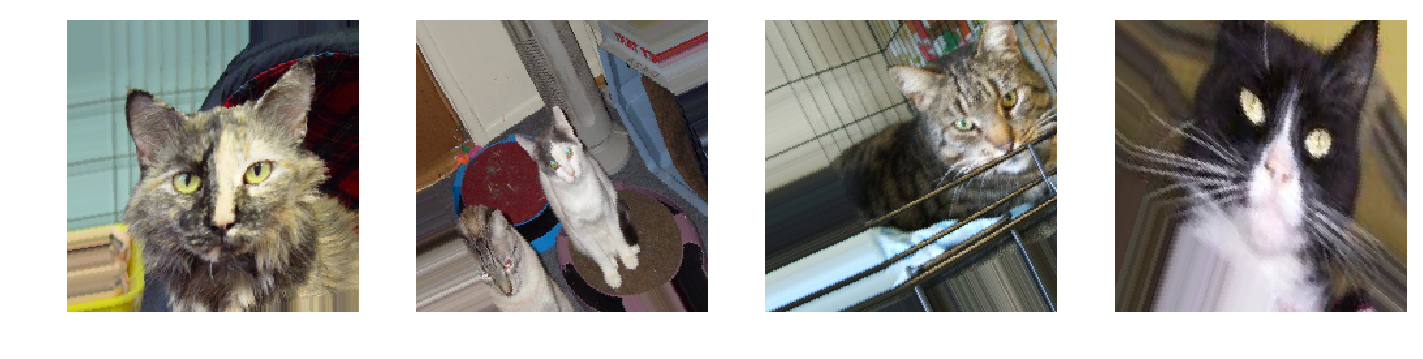

In [22]:
plots_idx(imagefiles[:4])

下一步，我们需要看的函数是 finetune 函数，看看里面到底做了什么

原vgg模型最后一层是一个输出为1000的FC层，此处我们需要将其去掉，然后改为我们需要的2分类器，代码如下：
```
def ft(self, num):
        """
            Replace the last layer of the model with a Dense (fully connected) layer of num neurons.
            Will also lock the weights of all layers except the new layer so that we only learn
            weights for the last layer in subsequent training.

            Args:
                num (int) : Number of neurons in the Dense layer
            Returns:
                None
        """
        model = self.model
        model.pop()
        for layer in model.layers: layer.trainable=False
        model.add(Dense(num, activation='softmax'))
        self.compile()
```

因此 finetune 中做的事情就是重新构建了下模型

接着到了最关键的 fit 方法了，具体训练模型了，方法可以参看[model](https://keras.io/models/model/)，fit 和 fit_generator 的区别是输入是否是 generator

In [23]:
print(keras.__version__)

2.0.8


In [24]:
model = Sequential()

In [25]:
#Signature: model.fit_generator(generator, samples_per_epoch, nb_epoch, 
#   verbose=1, callbacks=None, validation_data=None, nb_val_samples=None, class_weight=None,
#   max_q_size=10, nb_worker=1, pickle_safe=False, initial_epoch=0, **kwargs)
# model.fit_generator()
# 此处使用的 keras 的版本比较老，所有用的是老版本的接口

In [42]:
#import Vgg16 helper class
vgg = vgg16.Vgg16()

In [43]:
#Set constants. You can experiment with no_of_epochs to improve the model
batch_size=8
no_of_epochs=3

In [44]:
#Finetune the model
batches = vgg.get_batches(train_path, batch_size=batch_size)
val_batches = vgg.get_batches(valid_path, batch_size=batch_size*2)
vgg.finetune(batches)

#Not sure if we set this for all fits
vgg.model.optimizer.lr = 0.1
# vgg.model.compile(optimizer=)

Found 200 images belonging to 2 classes.
Found 50 images belonging to 2 classes.


In [45]:
# 换一个优化方法
from keras.optimizers import SGD, RMSprop
opt = RMSprop(lr=0.1)
vgg.model.compile(optimizer=opt,
                loss='categorical_crossentropy', metrics=['accuracy'])
# 此处优化算法换后，提升效果特别明显

In [47]:
#Notice we are passing in the validation dataset to the fit() method
#For each epoch we test our model against the validation set
latest_weights_filename = None
for epoch in range(no_of_epochs):
    print("Running epoch: %d" %(epoch))
    vgg.fit(batches, val_batches, nb_epoch=1)
    latest_weights_filename = 'ft%d.h5' % epoch
    vgg.model.save_weights(results_path+latest_weights_filename)
print("Completed %s fit operations"%(no_of_epochs))

此处有个大坑，我一上来就用了这么大的照片来训练，耗时严重，还不好调节参数，我们应该现在sample上验证完后，我们再放到真实数据上

## Generate Predictions

In [ ]:
batches, preds = vgg.test(test_path, batch_size = batch_size*2)

In [ ]:
#For every image, vgg.test() generates two probabilities 
#based on how we've ordered the cats/dogs directories.
#It looks like column one is cats and column two is dogs
print(preds[:5])

filenames = batches.filenames
print(filenames[:5])

In [ ]:
#You can verify the column ordering by viewing some images
from PIL import Image
Image.open(test_path + filenames[2])

In [ ]:
#Save our test results arrays so we can use them again later
save_array(results_path + 'test_preds.dat', preds)
save_array(results_path + 'filenames.dat', filenames)

## Validate Predictions
模型验证，我们主要看下面5类数据：

1. A few correct labels at random
2. A few incorrect labels at random
3. The most correct labels of each class (ie those with highest probability that are correct)
4. The most incorrect labels of each class (ie those with highest probability that are incorrect)
5. The most uncertain labels (ie those with probability closest to 0.5).

In [ ]:
vgg.model.load_weights(results_path+latest_weights_filename)

In [ ]:
val_batches, probs = vgg.test(valid_path, batch_size = batch_size)

In [ ]:
val_batches.class_indices

In [ ]:
filenames = val_batches.filenames
expected_labels = val_batches.classes #0 or 1

#Round our predictions to 0/1 to generate labels
our_predictions = probs[:,0] # 第一列都是表示猫的
our_labels = np.round(1-our_predictions)

In [ ]:
from keras.preprocessing import image

#Helper function to plot images by index in the validation set 
#Plots is a helper function in utils.py
def plots_idx(idx, titles=None):
    plots([image.load_img(valid_path + filenames[i]) for i in idx], titles=titles)
    
#Number of images to view for each visualization task
n_view = 4

In [ ]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(expected_labels, our_labels)

In [ ]:
plot_confusion_matrix(cm, val_batches.class_indices)

## Submit Predictions to Kaggle!
提交的形式是：
```
imageId,isDog
1242, .3984
3947, .1000
4539, .9082
2345, .0000
```

In [ ]:
#Load our test predictions from file
preds = load_array(results_path + 'test_preds.dat')
filenames = load_array(results_path + 'filenames.dat')

In [ ]:
#Extract imageIds from the filenames in our test/unknown directory 
filenames = batches.filenames
ids = np.array([int(f[8:f.find('.')]) for f in filenames])

In [ ]:
assert len(ids) == len(preds)

In [ ]:
subm = np.stack([ids,isdog], axis=1)
subm[:5]

In [ ]:
%cd $DATA_HOME_DIR
submission_file_name = 'submission1.csv'
np.savetxt(submission_file_name, subm, fmt='%d,%.5f', header='id,label', comments='')

In [ ]:
from IPython.display import FileLink
%cd $LESSON_HOME_DIR
FileLink('../data/redux/'+submission_file_name)

## 问题记录

1. 在aws环境搭建中，第一个问题是只支持3个地域，离中国太远了。慢，于是想个办法能不能用国内的？所以我换了Udacity-dl的ami，目前只能手动建立，做不到fast.ai中的命令行，暂时没有时间去研究那个脚本

2. 在mac上显示清晰问题
```
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
```